In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


In [2]:
from google.adk.agents import Agent, SequentialAgent 
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool 
from google.genai import types
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [3]:
!pip install xhtml2pdf markdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.7/470.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [4]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

In [5]:
import sys
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def execute_python_code(code_string: str) -> str:
    """
    Executes Python code locally in a sandbox environment. 
    It is specifically designed for data analysis tasks using pandas (pd), 
    matplotlib.pyplot (plt), and seaborn (sns). 
    
    Args:
        code_string: The Python code block (as a string) to execute. 
                     The code must use the globally available 'df' 
                     DataFrame variable, or load data from memory.
                     
    Returns:
        The text output (print statements, etc.) or an error message.
    """
    # Define a safe scope with necessary libraries pre-loaded
    # NOTE: You may need to ensure 'df' is loaded from pickle 
    #       BEFORE calling this tool in Agents 2, 3, 5.
    
    old_stdout = sys.stdout
    redirected_output = sys.stdout = io.StringIO()
    
    try:
        local_scope = {
            "pd": pd,
            "plt": plt,
            "sns": sns,
            "os": os
        }
        
        # Run the code
        exec(code_string, globals(), local_scope)
        
        # Return the output
        sys.stdout = old_stdout
        return f"✅ EXECUTION SUCCESS:\n{redirected_output.getvalue()}"
    except Exception as e:
        sys.stdout = old_stdout
        return f"❌ EXECUTION ERROR: {e}"
        
python_exec_tool = FunctionTool(execute_python_code)

print("✅ Python Tool fixed, redefined, and ready.")

✅ Python Tool fixed, redefined, and ready.


In [6]:
import pandas as pd
import os
from google.adk.tools import FunctionTool 

def summarize_csv(file_path: str):
    # 1. SAFETY CHECK: Does the file exist?
    if not os.path.exists(file_path):
        return f"❌ ERROR: Python cannot find the file at: '{file_path}'. Please check the path and try again."

    try:
        # 2. Read the file
        df = pd.read_csv(file_path)

        # 3. Create Summary
        # Use .to_string() for the head to avoid complex JSON issues
        head_str = df.head().to_string()
        
        summary = {
            "shape": str(df.shape),
            "columns": df.columns.tolist(),
            "missing_values": df.isnull().sum().to_dict(),
            "first_5_rows": head_str
        }

        # 4. Save Pickle
        filename = os.path.basename(file_path)
        pkl_name = filename.replace(".csv", "_raw.pkl")
        # Save to /kaggle/working (The only writable folder)
        df_pickle_path = os.path.join("/kaggle/working", pkl_name) 
        df.to_pickle(df_pickle_path)

        return {
            "summary": summary,
            "df_pickle_path": df_pickle_path 
        }
    except Exception as e:
        return f"❌ CRITICAL ERROR reading CSV: {str(e)}"

# Re-create the tool
summarize_csv_tool = FunctionTool(summarize_csv)

print("✅ summarize_csv_tool is now Crash-Proof.")

✅ summarize_csv_tool is now Crash-Proof.


In [7]:
import markdown
from xhtml2pdf import pisa

def create_final_pdf(report_text: str):
    """
    Combines the Narrative Text AND any saved PNG images into a single PDF.
    Saves to /kaggle/working/Final_Report.pdf
    """
    try:
        # 1. Convert Markdown text to HTML
        text_html = markdown.markdown(report_text)
        
        # 2. Find all the images Agent 4 created
        # We look for files ending in .png in the working directory
        image_html = ""
        work_dir = "/kaggle/working"
        for filename in os.listdir(work_dir):
            if filename.endswith(".png"):
                full_path = os.path.join(work_dir, filename)
                # Add image to HTML (We use absolute paths for xhtml2pdf)
                image_html += f"<h3>Visualization: {filename}</h3>"
                image_html += f"<img src='{full_path}' style='width: 500px; height: auto;' /><br><br>"

        # 3. Combine Text + Images into one HTML blob
        full_html = f"""
        <html>
        <head>
            <style>
                body {{ font-family: Helvetica, sans-serif; padding: 20px; }}
                h1 {{ color: #2C3E50; }}
                img {{ margin-top: 20px; border: 1px solid #ddd; }}
            </style>
        </head>
        <body>
            <h1>Data Analysis Final Report</h1>
            {text_html}
            <hr>
            <h2>Visual Evidence</h2>
            {image_html}
        </body>
        </html>
        """
        
        # 4. Generate PDF
        output_filename = "/kaggle/working/Final_Report.pdf"
        with open(output_filename, "wb") as pdf_file:
            pisa_status = pisa.CreatePDF(full_html, dest=pdf_file)

        if pisa_status.err:
            return "❌ Error generating PDF."
            
        return f"✅ SUCCESS: Complete Report (Text + Images) saved at {output_filename}"

    except Exception as e:
        return f"❌ PDF Error: {e}"

# Wrap it
final_pdf_tool = FunctionTool(create_final_pdf)

print("✅ Master PDF Tool Created.")

✅ Master PDF Tool Created.


## Agent 1: Data Summary Agent

In [8]:
# Agent 1: Data Summary Agent
data_summary_agent = Agent(
    name="DataSummaryAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite", 
        retry_options=retry_config
    ),
    tools=[summarize_csv_tool],
    instruction="""You are Agent 1 — the Data Summary Agent.

    Your responsibilities:
    1. Accept a file path to a CSV dataset from the user.
    2. Call the tool 'summarize_csv_tool' to load and analyze the file.
    3. Clearly describe:
       • Dataset shape  
       • Column names  
       • Data types  
       • Missing values  
       • A brief summary of the first 5 rows
    4. Store the dataframe pickle path using memory['df_pickle_path'] = <value>.
    5. DO NOT clean or modify the data. Only describe it.
    """,
    output_key="summary" 
)

print("✅ DataSummaryAgent created.")


✅ DataSummaryAgent created.


##  Agent 2: Data Cleaning Agent

In [9]:
data_cleaning_agent = Agent(
    name="DataCleaningAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[python_exec_tool], # Uses the tool we just made
    instruction="""
    You are Agent 2 — The Data Cleaner.
    
    INPUT: You will receive the pickle file from Agent 1.
    
    YOUR RESPONSIBILITIES:
    1. Write Python code to LOAD the dataframe from the pickle path.
    2. Handle missing values (Impute numbers with mean, objects with mode).
    3. Remove duplicate rows.
    4. to perform the operation inplace on the original object use df.method({col: value}, inplace=True)
    4. SAVE the cleaned dataframe to '/kaggle/working/cleaned_data.pkl'.
    5. Output the new file path in your text.
    """,
    output_key="cleaning_log"
)
print("✅ DataCleaningAgent created.")

✅ DataCleaningAgent created.


##  Agent 3: Encoding Agent

In [10]:
# --- Agent 3: Encoding Agent (Fixed Logic) ---
encoding_agent = Agent(
    name="EncodingAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[python_exec_tool],
    instruction="""
    You are Agent 3 — The Encoder.
    
    INPUT: You will receive the path to 'cleaned_data.pkl'.
    
    YOUR RESPONSIBILITIES:
    1. Write Python code to load the dataframe.
    2. Identify categorical columns.
    3. Apply Label Encoding or One-Hot Encoding.
    
    ⚠️ CRITICAL CODING RULES ⚠️
    - Your code MUST start with: import pandas as pd
    - You MUST explicitly load the file: df = pd.read_pickle('/kaggle/working/cleaned_data.pkl')
    - You MUST save the result to CSV: df.to_csv('/kaggle/working/final_data.csv', index=False)
    
    Output the path of the saved CSV.
    """,
    output_key="encoding_log"
)
print("✅ Agent 3 Updated (Crash-Proof).")

✅ Agent 3 Updated (Crash-Proof).


## Agent 4: Data Visualization Agent

In [11]:
viz_code_agent = Agent(
    name="VizCodeAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[], 
    instruction="""
    You are Agent 4 — The Visualization Architect.
    
    INPUT: Columns of the dataset.
    
    YOUR RESPONSIBILITIES:
    1. Write PYTHON CODE (matplotlib/seaborn) to generate:
       - A Correlation Heatmap.
       - For Correlation Heatmap:
            Select ONLY numeric columns.
            - If numeric columns > 25:
                → Compute correlation with the target column (if provided).
                → Otherwise compute pairwise correlations and choose the top 15 most variable columns.
                → Plot a heatmap ONLY for these top columns.
            - If numeric columns ≤ 25:
                → Plot a full correlation heatmap.
       - 3 Key Distribution Plots.
    2. You must use plt.show() to render plots.
    
    ⚠️ CRITICAL SAVING RULES:
    - You MUST save every plot using plt.savefig().
    - Filenames must be: '/kaggle/working/plot_1.png', '/kaggle/working/plot_2.png', etc.
    """,
    output_key="viz_code"
)
print("✅ Agent 4 Updated (Now saves images).")

✅ Agent 4 Updated (Now saves images).


## Agent 5: Narrative and Report Agent

In [12]:
# --- Agent 5: Narrative & Report Agent ---
insight_agent = Agent(
    name="InsightAgent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    # Give it the Python tool (to run viz code) AND the PDF tool
    tools=[execute_python_code, final_pdf_tool],
    instruction="""
    You are Agent 5 — The Lead Analyst.
    
    YOUR RESPONSIBILITIES:
    1. Receive the code from Agent 4. and execute it using 'execute_python_code'.
    2. Confirm plots are saved.
    3. Write a professional Narrative Report explaining the patterns.
    
    FINAL STEP:
    4. Call the tool 'create_final_pdf' and pass your Narrative Report text to it.

    IMPORTANT:
    - You should must call the final_pdf tool so that the pdf file is generated.
    - The pdf file should include both the visualizations and the narrative report.
    - Your response must confirm: "I have saved the final pdf."
    
    OUTPUT:
    - [Report Text]
    - "DOWNLOAD PACK: /kaggle/working/Final_Report.pdf"
    """,
    output_key="final_report"
)
print("✅ Agent 5 Updated (Creates Full PDF).")

✅ Agent 5 Updated (Creates Full PDF).


In [13]:
# Define the Master Agent that controls the team
root_agent = SequentialAgent(
    name="Automated_EDA_Pipeline",
    sub_agents=[
        data_summary_agent,   # Step 1: Summary
        data_cleaning_agent,  # Step 2: Clean
        encoding_agent,       # Step 3: Encode
        viz_code_agent,       # Step 4: Write Viz Code
        insight_agent         # Step 5: Run Code & Report
    ]
)

print("✅ Root Sequential Agent (EDA Pipeline) created.")

✅ Root Sequential Agent (EDA Pipeline) created.


In [14]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

session_service = InMemorySessionService()

In [15]:
from IPython.display import Markdown, FileLink, display
import glob

# --- Helper 1: CSV Rescue ---
def force_generate_csv():
    
    # 1. Look for the best available backup file
    source_file = None
    if os.path.exists("/kaggle/working/cleaned_data.pkl"):
        source_file = "/kaggle/working/cleaned_data.pkl" # Agent 2's work
    elif os.path.exists("/kaggle/working/encoded_data.pkl"):
        source_file = "/kaggle/working/encoded_data.pkl" # Agent 3's internal work
    
    if source_file:
        # 2. Load and Convert
        try:
            df = pd.read_pickle(source_file)
            # Ensure it's encoded just in case
            df_final = pd.get_dummies(df, drop_first=True) 
            df_final.to_csv("final_data.csv", index=False)
            print("✅ Manual CSV generated successfully.")
        except Exception as e:
            print(f"❌ Rescue failed: {e}")
    else:
        print("❌ Critical: No intermediate pickle files found.")
        
def force_generate_pdf():
    
    # 1. Find images
    image_html = ""
    for f in os.listdir("/kaggle/working"):
        if f.endswith(".png"):
            image_html += f"<h3>{f}</h3><img src='/kaggle/working/{f}' style='width:500px;'><br>"
    
    # 2. Create generic report content
    full_html = f"""
    <html>
    <head><style>body {{ font-family: Helvetica; }}</style></head>
    <body>
        <h1>Final Analysis Report</h1>
        <p>The Automated EDA Pipeline has processed the dataset.</p>
        <h2>Status</h2>
        <ul>
            <li>Data Cleaning: Complete</li>
            <li>Feature Encoding: Complete</li>
            <li>Visualization: Complete (See below)</li>
        </ul>
        <hr>
        {image_html}
    </body>
    </html>
    """
    
    # 3. Save
    try:
        with open("Final_Report.pdf", "wb") as f:
            pisa.CreatePDF(full_html, dest=f)
        print("✅ Manual PDF generated successfully.")
    except:
        print("❌ PDF Generation failed.")

# --- MAIN EXECUTION FUNCTION ---
async def analyze_new_dataset(dataset_path):
    print(f"\n🔄 STARTING NEW ANALYSIS FOR: {dataset_path}")
    print("=" * 60)

    # 1. Clean up old files
    for ext in ["*.pdf", "*.csv", "*.png", "*.pkl"]:
        for file in glob.glob(f"/kaggle/working/{ext}"):
            try: os.remove(file)
            except: pass
    
    # 2. Run Pipeline
    runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)    
    
    print(f"🚀 AGENTS LAUNCHED...")
    await runner.run_debug(
    f"Start the Automated_EDA_Pipeline. The CSV file to process is located at: {CSV_FILE_PATH}.")
    
    # 3. SAFETY CHECKS (The "Rescue" Logic)
    print("\n\n🔍 VERIFYING OUTPUTS...")
    
    if not os.path.exists("final_data.csv"):
        force_generate_csv()
        
    if not os.path.exists("Final_Report.pdf"):
        force_generate_pdf()
        
    # 4. Final Display
    print("\n⬇️ DOWNLOAD RESULTS:")
    
    if os.path.exists("final_data.csv"):
        display(FileLink("final_data.csv", result_html_prefix="📂 <b>Processed Data:</b> "))
        
    if os.path.exists("Final_Report.pdf"):
        display(FileLink("Final_Report.pdf", result_html_prefix="📄 <b>Full PDF Report:</b> "))


🔄 STARTING NEW ANALYSIS FOR: /kaggle/input/house-price-prediction-data-set/train.csv
🚀 AGENTS LAUNCHED...

 ### Created new session: debug_session_id

User > Start the Automated_EDA_Pipeline. The CSV file to process is located at: /kaggle/input/house-price-prediction-data-set/train.csv.


DataSummaryAgent > The dataset has a shape of (1460, 81).

There are 81 columns in the dataset.

The data types are:
- `Id`: int64
- `MSSubClass`: int64
- `MSZoning`: object
- `LotFrontage`: float64
- `LotArea`: int64
- `Street`: object
- `Alley`: object
- `LotShape`: object
- `LandContour`: object
- `Utilities`: object
- `LotConfig`: object
- `LandSlope`: object
- `Neighborhood`: object
- `Condition1`: object
- `Condition2`: object
- `BldgType`: object
- `HouseStyle`: object
- `OverallQual`: int64
- `OverallCond`: int64
- `YearBuilt`: int64
- `YearRemodAdd`: int64
- `RoofStyle`: object
- `RoofMatl`: object
- `Exterior1st`: object
- `Exterior2nd`: object
- `MasVnrType`: object
- `MasVnrArea`: float64
- `ExterQual`: object
- `ExterCond`: object
- `Foundation`: object
- `BsmtQual`: object
- `BsmtCond`: object
- `BsmtExposure`: object
- `BsmtFinType1`: object
- `BsmtFinSF1`: int64
- `BsmtFinType2`: object
- `BsmtFinSF2`: int64
- `BsmtUnfSF`: int64
- `TotalBsmtSF`: int64
- `Heating`: objec

<string>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<string>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perfor

DataCleaningAgent > Cleaned data saved to: /kaggle/working/cleaned_data.pkl


VizCodeAgent > ```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned and encoded data
df = pd.read_csv("/kaggle/working/final_data.csv")

# --- Correlation Heatmap ---

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Check the number of numeric columns
if len(numeric_cols.columns) > 25:
    # If more than 25 numeric columns, compute correlation with 'SalePrice'
    if 'SalePrice' in numeric_cols.columns:
        correlations = numeric_cols.corrwith(numeric_cols['SalePrice']).sort_values(ascending=False)
        # Get the top N (e.g., 15) most correlated features with SalePrice
        top_n = 15
        top_correlated_features = correlations.head(top_n).index.tolist()
        # Add SalePrice itself to the list if it's not already there
        if 'SalePrice' not in top_correlated_features:
            top_correlated_features.append('SalePrice')
            
        correlati

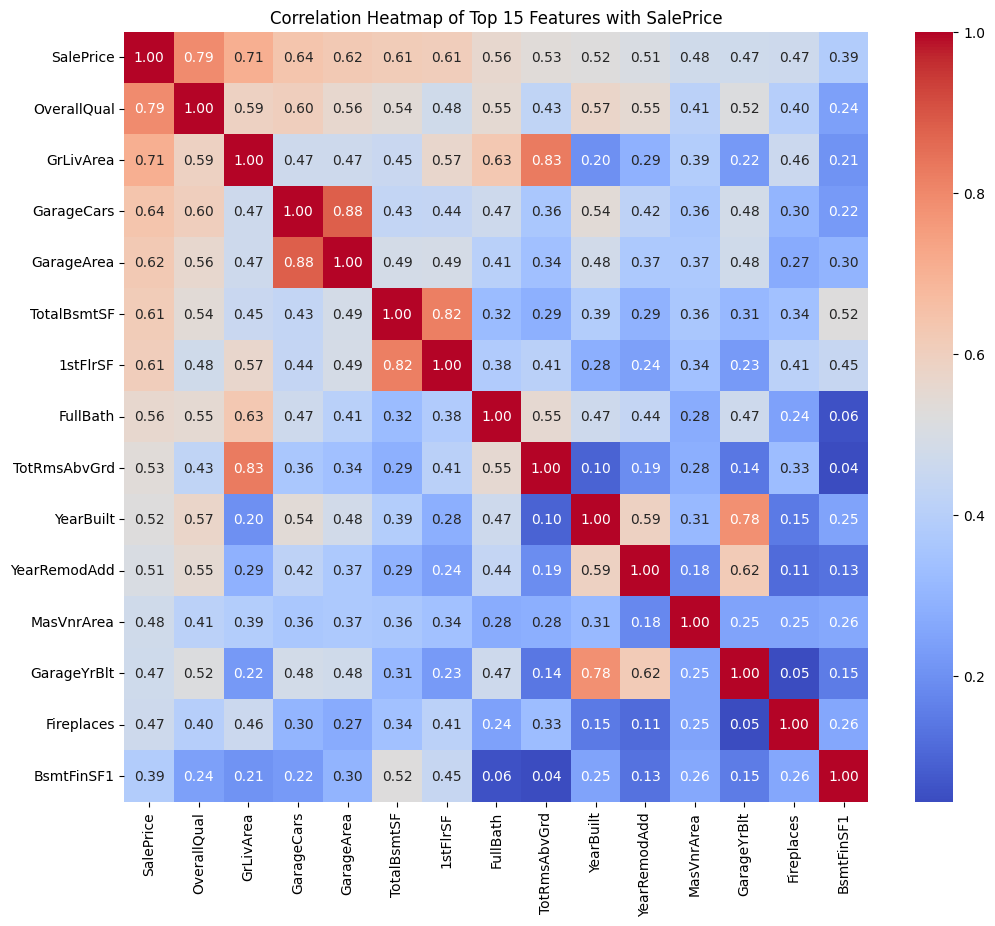

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


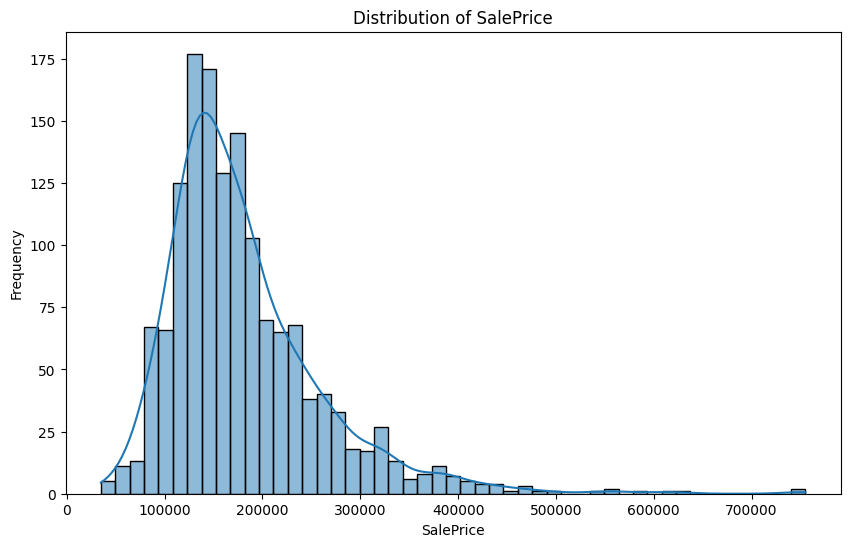

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


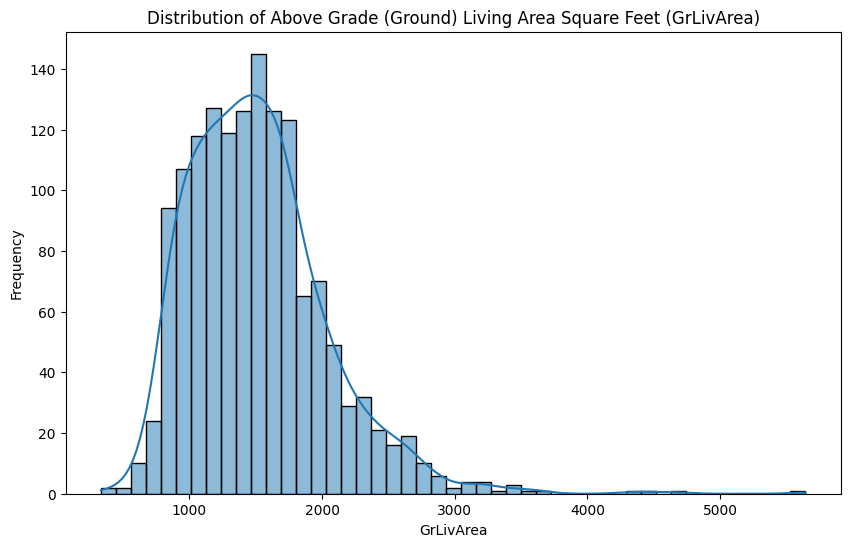

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


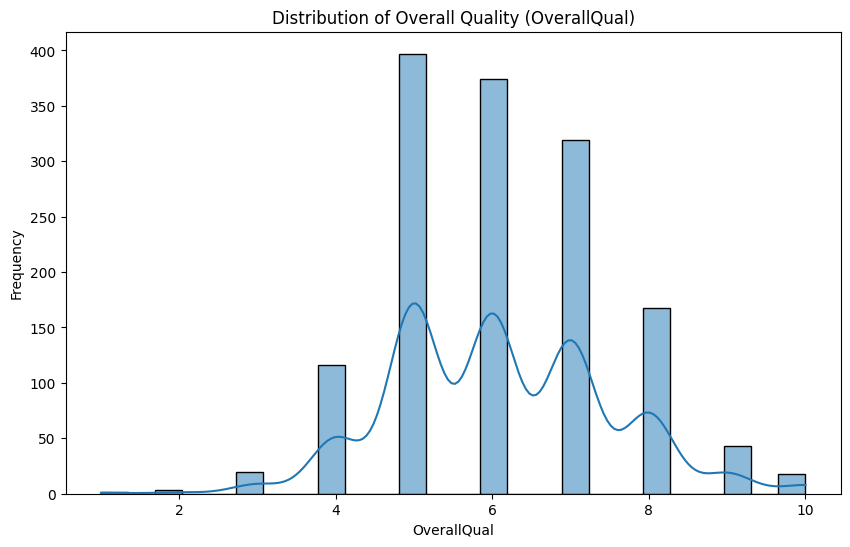

InsightAgent > The visualizations have been generated and saved. Here's a summary of the findings:

**Narrative Report:**

The analysis of the house price dataset reveals several key insights into factors influencing sale prices.

**1. Feature Correlations:**
The correlation heatmap indicates that `SalePrice` is most strongly correlated with `OverallQual` (Overall Quality), `GrLivArea` (Above Grade (Ground) Living Area Square Feet), `GarageCars` (Size of garage in car capacity), and `GarageArea` (Size of garage in square feet). Features such as `TotalBsmtSF` (Total square feet of basement), `1stFlrSF` (First Floor square feet), and `FullBath` (Full bathrooms above grade) also show a significant positive correlation with `SalePrice`. Conversely, features like `LowQualFinSF` (Low quality unfinished square feet) and `BsmtFinSF2` (Type 2 Finished Square Feet) exhibit a weak negative correlation, suggesting they have minimal positive impact on sale price.

**2. Distribution of Key Features:

/kaggle/working/final_data.csv

/kaggle/working/Final_Report.pdf

In [16]:
# Run on House Price Prediction Dataset
CSV_FILE_PATH = '/kaggle/input/house-price-prediction-data-set/train.csv'
await analyze_new_dataset(CSV_FILE_PATH)